In [6]:
from AllMethods import all

ValueError: attempted relative import beyond top-level package

## Perturbed Pendulum: Reversible Henon Maps

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import os
import time
import wandb

## $\begin{pmatrix} x \\ y \end{pmatrix} \mapsto \begin{pmatrix}y \\ -x + w_{0} + w_{1}y + w_{2}y^{2} + w_{3}y^{3} + w_{4}y^{4} \end{pmatrix}$

### Import Training Dataset

In [2]:
file = open("x_train_PPH.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()


Nlines = int(line_count/2)

u0 = []

prova = open("x_train_PPH.txt", "r")
for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    u0.append(np.array([x,y]))
prova.close()

T = []

prova = open("y_train_PPH.txt", "r")

for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    T.append(np.array([x,y]))
prova.close()

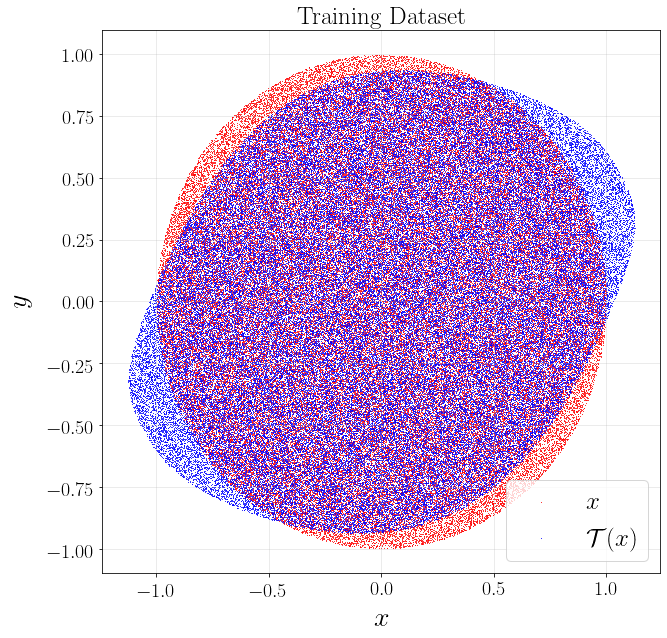

In [3]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Training Dataset', fontsize = 25)
plt.scatter([u0[i][0] for i in range(len(u0))], [u0[i][1] for i in range(len(u0))], label = r'$x$', linewidth = 0, color ='r', s=1)
plt.scatter([T[i][0] for i in range(len(u0))], [T[i][1] for i in range(len(u0))], label = r'$\mathcal{T}(x)$', linewidth = 0, color = 'b', s=1)
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)
#plt.savefig("DoublePendulum_Example")
plt.show()

### Training Dataset

In [4]:
x_train = np.array(u0)
x_train = x_train.astype(np.float32)

y_train = np.array(T)
y_train = y_train.astype(np.float32)



x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(10000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(10000)

train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

----------------------
----------------------
----------------------

### Custom Layer

In [5]:
class H(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(5,),
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
        trainable = True
        )

    def call(self, x, inverse):
        
        if inverse == 0:
        
            L0 = tf.concat([[[1., 0.],[0., 0.]]], 0)
            L10 = tf.concat([[[0., 0.],[0., -1]]], 0)

            L1 = tf.concat([[[0., 0.],[0., self.w[0]]]], 0)
            L2 = tf.concat([[[0., 0.],[0., self.w[1]]]], 0)
            L3 = tf.concat([[[0., 0.],[0., self.w[2]]]], 0)
            L4 = tf.concat([[[0., 0.],[0., self.w[3]]]], 0)
            #L5 = tf.concat([[[0., 0.],[0., self.w[4]]]], 0)


            x̄ = tf.reverse(x, [1])
            b = tf.constant([[0., 1.]])

            return tf.linalg.matvec(L0, x̄) + tf.linalg.matvec(L10, x̄) + tf.linalg.matvec(L1, b) + tf.linalg.matvec(L2, x) + tf.linalg.matvec(L3, x)*x + tf.linalg.matvec(L4, x)*x*x #+ tf.linalg.matvec(L5, x)*x*x*x
        
        else:
            
            L0 = tf.concat([[[0., 0.],[0., 1.]]], 0)
            L10 = tf.concat([[[-1., 0.],[0., 0.]]], 0)

            L1 = tf.concat([[[self.w[0], 0.],[0., 0.]]], 0)
            L2 = tf.concat([[[self.w[1], 0.],[0., 0.]]], 0)
            L3 = tf.concat([[[self.w[2], 0.],[0., 0.]]], 0)
            L4 = tf.concat([[[self.w[3], 0.],[0., 0.]]], 0)
            #L5 = tf.concat([[[self.w[4], 0.],[0., 0.]]], 0)
            
            
            x̄ = tf.reverse(x, [1])
            b = tf.constant([[1., 0.]])
            
            return tf.linalg.matvec(L0, x̄) + tf.linalg.matvec(L10, x̄) + tf.linalg.matvec(L1, b) + tf.linalg.matvec(L2, x) + tf.linalg.matvec(L3, x)*x + tf.linalg.matvec(L4, x)*x*x #+ tf.linalg.matvec(L5, x)*x*x*x

### Model

In [6]:
class Henon(keras.Model):
    
    def __init__(self, N):
        
        super().__init__()
        
        self.Hs = []
        for i in range(N):
            self.Hs.append(H())


    def call(self, input_tensor):
    
        boom = input_tensor
        for i in range(len(self.Hs)):
            boom = self.Hs[i](boom, 0)
            
        boom = boom*tf.constant([1., -1.])
        
        for i in range(1, len(self.Hs)):
            boom = self.Hs[-i](boom, 1)

        boom = self.Hs[0](boom, 1)*tf.constant([1., -1.])
        
        return boom

In [7]:
model = Henon(25)

### Training

In [8]:
# DECAYING LEARNING RATE

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
#import tensorflow_probability as tfp
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    #metrics=["accuracy"],
)

In [10]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[callback], verbose=1)
print("running time : %s seconds" % (time.time() - start_time))

Epoch 1/10
9/9 [==============================] - 6s 642ms/step - loss: 0.0148 - val_loss: 0.0082
Epoch 2/10
9/9 [==============================] - 3s 327ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 3/10
9/9 [==============================] - 3s 326ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 4/10
9/9 [==============================] - 3s 326ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/10
9/9 [==============================] - 3s 327ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/10
9/9 [==============================] - 3s 327ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 7/10
9/9 [==============================] - 3s 326ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 8/10
9/9 [==============================] - 3s 334ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/10
9/9 [==============================] - 3s 341ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/10
9/9 [==============================] - 3s 350ms/step - loss: 0.0028 - val_loss: 0.0025
running time : 54.3

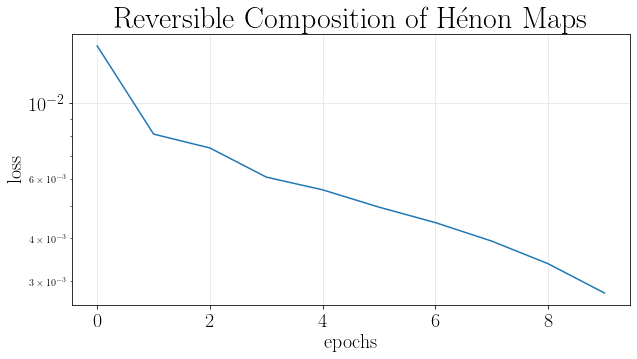

In [11]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

### Export the training and validation loss

In [17]:
os.remove("Loss1.txt")
f = open("Loss1.txt", "a")
for i in history.history["loss"]:
    f.write(str(i))
    f.write("\n")
f.close()

os.remove("Val1.txt")
f = open("Val1.txt", "a")
for i in history.history["val_loss"]:
    f.write(str(i))
    f.write("\n")
f.close()

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'Loss1.txt'

## Tests

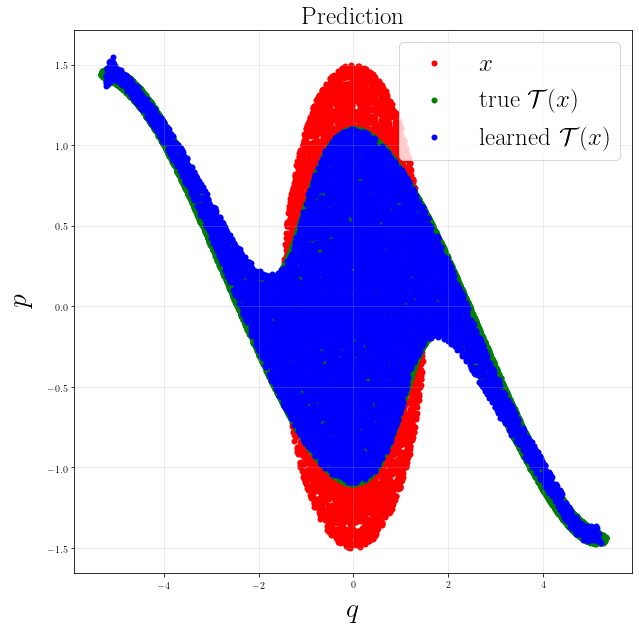

In [112]:
u = model(x_train)

Nplot = Nlines

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)
plt.scatter([x_train[i][0] for i in range(len(x_train))], [x_train[i][1] for i in range(len(x_train))], label = r'$x$', linewidth = 0, color ='r', s=1)
plt.scatter([T[i][0] for i in range(len(x_train))], [T[i][1] for i in range(len(x_train))], label = r'$\mathcal{T}(x)$', linewidth = 0, color ='b', s=1)
plt.scatter([u[i][0].numpy() for i in range(len(x_train))], [u[i][1].numpy() for i in range(len(x_train))], label = r'$\hat{\mathcal{T}}(x)$', linewidth = 0, color ='g', s=1)
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)
#plt.savefig("DoublePendulum_Example")
plt.show()

### True Poincare Plot

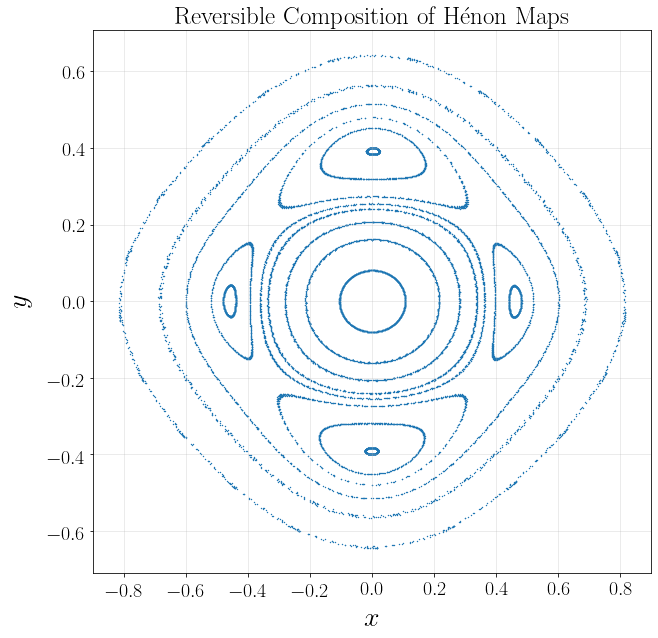

In [3]:
file = open("Poincare.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()


Nlines = int(line_count/2)

Poincare_points = []

prova = open("Poincare.txt", "r")
for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    Poincare_points.append(np.array([x,y]))
prova.close()

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)

plt.scatter([i[0] for i in Poincare_points], [i[1] for i in Poincare_points], linewidth = 0, s=2)

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.show()

### Iterations

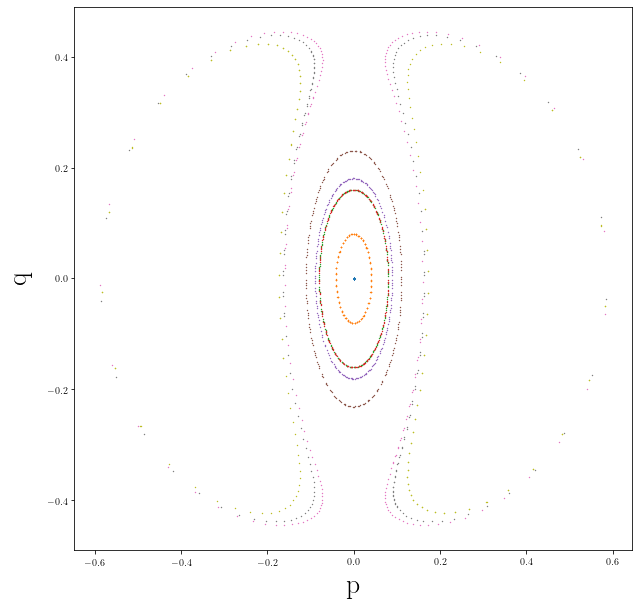

In [113]:
x0 = np.array([[0.0, 0.1],[0.0, 0.2],[0.0, 0.3],[0.0, 0.4],[0.0, 0.5],[0.0, 0.6],[0.1, 0.],[0.2, 0.],[0.3, 0.],[0.4, 0.],[0.5, 0.]])

iterations = [model(x0)]
for _ in range(200):
    iterations.append(model(iterations[-1]))

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0)
    
plt.scatter(*zip(*x0.numpy()), s=15, linewidth=0)

plt.scatter([i[0] for i in Poincare_points], [i[1] for i in Poincare_points], linewidth = 0, s=2)

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.show()

### Reversibility

In [ ]:
x0 = np.array([[rd.randrange(250, 300, 1)*0.001, rd.randrange(250, 300, 1)*0.001] for _ in range(100)])

f_iterations = [model(x0)]
for _ in range(100):
    f_iterations.append(model(f_iterations[-1]))

b_iterations = [f_iterations[-1]*np.array([[1., -1.]])]
for _ in range(100):
    b_iterations.append(model(b_iterations[-1]))

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 25)


plt.scatter(*zip(*f_iterations[0].numpy()), s=1, linewidth=0, color='r', label= r'$\hat{\mathcal{T}}^{n}[X_{0}] \qquad n=1,\dots ,100$')

for i in f_iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color='r')
    
#plt.scatter(*zip(*f_iterations[-1].numpy()), s=15, linewidth=0, color='r')

#plt.scatter(*zip(*b_iterations[0].numpy()), s=15, linewidth=0, color='b')

b_iterations_symm = b_iterations*np.array([[1., -1.]])

plt.scatter(*zip(*b_iterations_symm[0]), s=1, linewidth=0, color='b', label= r'$R \hat{\mathcal{T}}^{n}[R(\hat{\mathcal{T}}^{100}(X_{0}))] \qquad n=1,\dots 100$')

for i in b_iterations_symm:
    plt.scatter(*zip(*i), s=1, linewidth=0, color='b')

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(scatterpoints=1, fontsize=25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#plt.savefig("Testing_Reversinility_NonReversible.png")
plt.show()

### Quantitative Test for Reversibility

In [ ]:
A = np.array(f_iterations)
B = np.flip(b_iterations_symm, 0)

(np.square(A - B)).mean(axis=None)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------

### Three iterations Poincare plot

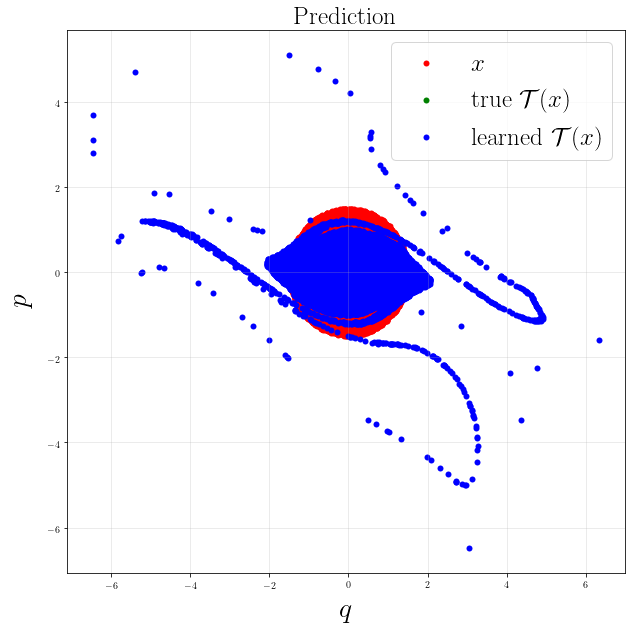

In [269]:
file = open("x_train_PPH_2iter.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()


Nlines = int(line_count/2)

u0 = []

prova = open("x_train_PPH_2iter.txt", "r")
for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    u0.append(np.array([x,y]))
prova.close()

T = []

prova = open("y_train_PPH_2iter.txt", "r")

for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    T.append(np.array([x,y]))
prova.close()


u = model(x_train)
u = model(u)

Nplot = 10000

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Prediction', fontsize = 25)
plt.scatter([x_train[i][0] for i in range(Nplot)], [x_train[i][1] for i in range(Nplot)], label = r'$x$', linewidth = 0, color ='r')
plt.scatter([T[i][0] for i in range(len(u0))], [T[i][1] for i in range(len(u0))], label = r'true $\mathcal{T}(x)$', linewidth = 0, color = 'g')
plt.scatter([u[i][0].numpy() for i in range(Nplot)], [u[i][1].numpy() for i in range(Nplot)], label = r'learned $\mathcal{T}(x)$', linewidth = 0, color ='b')
plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)

#plt.savefig("DoublePendulum_Example")

plt.show()